This Colab notebook focuses on predicting the solubility values of molecules (ESOL) based on their structure in SMILES format. The prediction is performed using a transformer model, specifically the ChemBERTa model.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/bert-loves-chemistry

[Errno 2] No such file or directory: '/content/bert-loves-chemistry'
/content


In [ ]:
!pwd

/content


In [ ]:
import os
!pip install deepchem

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from typing import List
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
import logging
import sys

from deepchem.molnet import load_bbbp, load_clearance, load_clintox, load_delaney, load_hiv, load_qm7, load_tox21
from rdkit import Chem
import deepchem
import sklearn.metrics


Instructions for updating:
experimental_relax_shapes is deprecated, use reduce_retracing instead


In [ ]:
new_df = pd.read_csv("/content/drive/MyDrive/delaney-processed.csv")
new_df

,Compound ID,ESOL predicted log solubility in mols per litre,Minimum Degree,Molecular Weight,Number of H-Bond Donors,Number of Rings,Number of Rotatable Bonds,Polar Surface Area,measured log solubility in mols per litre,smiles
0,Amigdalin,-0.974,1,457.432,7,3,7,202.32,-0.770,OCC3OC(OCC2OC(OC(C#N)c1ccccc1)C(O)C(O)C2O)C(O)...
1,Fenfuram,-2.885,1,201.225,1,2,2,42.24,-3.300,Cc1occc1C(=O)Nc2ccccc2
2,citral,-2.579,1,152.237,0,0,4,17.07,-2.060,CC(C)=CCCC(C)=CC(=O)
3,Picene,-6.618,2,278.354,0,5,0,0.00,-7.870,c1ccc2c(c1)ccc3c2ccc4c5ccccc5ccc43
4,Thiophene,-2.232,2,84.143,0,1,0,0.00,-1.330,c1ccsc1
...,...,...,...,...,...,...,...,...,...,...
1123,halothane,-2.608,1,197.381,0,0,0,0.00,-1.710,FC(F)(F)C(Cl)Br
1124,Oxamyl,-0.908,1,219.266,1,0,1,71.00,0.106,CNC(=O)ON=C(SC)C(=O)N(C)C
1125,Thiometon,-3.323,1,246.359,0,0,7,18.46,-3.091,CCSCCSP(=S)(OC)OC
1126,2-Methylbutane,-2.245,1,72.151,0,0,1,0.00,-3.180,CCC(C)C


Split the data to train, test and validation

In [ ]:
new_train_data, new_test_data = train_test_split(new_df, test_size=0.2, random_state=42)
new_train_data, new_validation_data =train_test_split(new_train_data, test_size=0.2, random_state=42)


In [ ]:
columns_to_drop=['Compound ID','ESOL predicted log solubility in mols per litre','Minimum Degree','Molecular Weight','Number of H-Bond Donors','Number of Rings','Number of Rotatable Bonds','Polar Surface Area']
for df in [new_train_data, new_test_data, new_validation_data]:
    df.drop(columns=columns_to_drop, inplace=True)

In [ ]:
new_train_data

,measured log solubility in mols per litre,smiles
451,-5.184,CC(=O)OC3CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C
1055,-2.110,CCCCC(CC)CO
881,-1.280,CNc1ccccc1
11,-4.140,Clc1ccc2ccccc2c1
434,-5.240,CC34CCc1c(ccc2cc(O)ccc12)C3CCC4=O
...,...,...
837,-2.564,COc1ccc(NC(=O)N(C)C)cc1Cl
587,-4.210,c1c(NC(=O)c2ccccc2(I))cccc1
776,-3.270,CC1=CCCCC1
153,-2.730,CCCCCCl


In [ ]:
new_test_data

,measured log solubility in mols per litre,smiles
1091,-2.540,CC/C=C\C
898,-2.253,O=C1NC(=O)NC(=O)C1(CC)CC=C(C)C
739,-2.484,Cc1[nH]c(=O)n(c(=O)c1Cl)C(C)(C)C
140,-2.540,CC/C=C/C
1019,-7.200,ClC(Cl)C(c1ccc(Cl)cc1)c2ccc(Cl)cc2
...,...,...
336,-4.600,o1c2ccccc2c3ccccc13
429,-5.259,ClC1(C(=O)C2(Cl)C3(Cl)C14Cl)C5(Cl)C2(Cl)C3(Cl)...
12,-2.680,CCCC=C
1036,-2.593,O=C1NC(=O)NC(=O)C1(C(C)C)CC=C(C)C


In [ ]:
new_validation_data

,measured log solubility in mols per litre,smiles
60,-9.150,Clc1cc(Cl)c(Cl)c(c1Cl)c2c(Cl)c(Cl)cc(Cl)c2Cl
706,-0.820,c1ccoc1
1077,-1.890,CCCCCOC(=O)C
179,-2.337,CCC1(CCC(=O)NC1=O)c2ccccc2
745,-3.538,CCCC1C(=O)N3N(C1=O)c2cc(C)ccc2N=C3N(C)C
...,...,...
13,-2.640,CCC1(C(=O)NCNC1=O)c2ccccc2
188,-7.320,C1C(O)CCC2(C)CC3CCC4(C)C5(C)CC6OCC(C)CC6OC5CC4...
484,-1.910,BrC(Br)Br
6,-7.320,Clc1cc(Cl)c(c(Cl)c1)c2c(Cl)cccc2Cl


Distribution of solubility values in train data

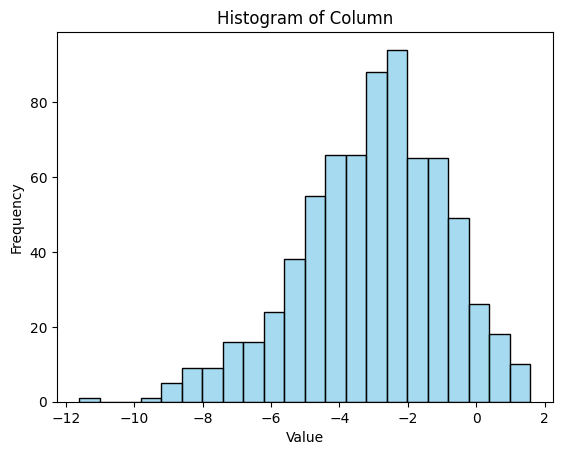

In [ ]:
# Create the histogram using Seaborn
sns.histplot(new_train_data['measured log solubility in mols per litre'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Column')

# Show plot
plt.show()


Distribution of solubility values in test data

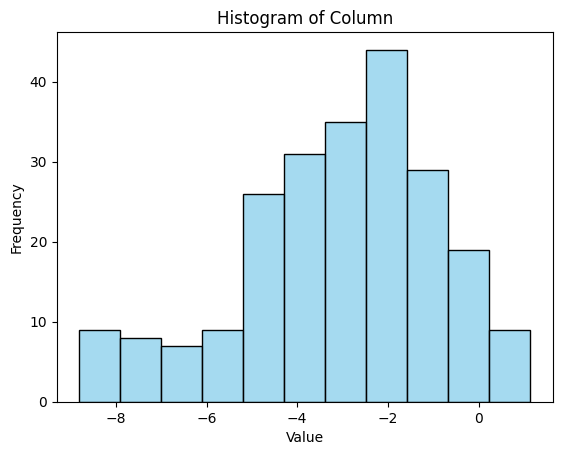

In [ ]:
# Create the histogram using Seaborn
sns.histplot(new_test_data['measured log solubility in mols per litre'], color='skyblue', edgecolor='black')

# Add labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Column')

# Show plot
plt.show()


In [ ]:
!pip install transformers

In [ ]:
#!pip install pyarrow==3.0.0
#!pip install pyarrow==5.0.0
!pip install simpletransformers

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 42.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 60.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 75.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 195.4/195.4 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.5/258.5 kB 37.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 17.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 95.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 15.

In [ ]:
!curl -Lo conda_installer.py https://raw.githubusercontent.com/deepchem/deepchem/master/scripts/colab_install.py
conda_installer.install()
!/root/miniconda/bin/conda info -e


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3457  100  3457    0     0   6451      0 --:--:-- --:--:-- --:--:--  6449


add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
INFO:conda_installer:add /root/miniconda/lib/python3.10/site-packages to PYTHONPATH
python version: 3.10.12
INFO:conda_installer:python version: 3.10.12
fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
INFO:conda_installer:fetching installer from https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
done
INFO:conda_installer:done
installing miniconda to /root/miniconda
INFO:conda_installer:installing miniconda to /root/miniconda
done
INFO:conda_installer:done
installing openmm, pdbfixer
INFO:conda_installer:installing openmm, pdbfixer
added conda-forge to channels
INFO:conda_installer:added conda-forge to channels
done
INFO:conda_installer:done
conda packages installation finished!
INFO:conda_installer:conda packages installation finished!


# conda environments:
#
base                     /root/miniconda



In [ ]:
!pip install --pre deepchem
deepchem.__version__

'2.7.1'

In [ ]:
!git clone https://github.com/NVIDIA/apex
!cd /content/apex
!pip install -v --no-cache-dir /content/apex
!pip install transformers
!pip install simpletransformers
!pip install wandb
!cd ..

Cloning into 'apex'...
remote: Enumerating objects: 11632, done.
remote: Counting objects: 100% (3725/3725), done.
remote: Compressing objects: 100% (573/573), done.
remote: Total 11632 (delta 3370), reused 3277 (delta 3149), pack-reused 7907
Receiving objects: 100% (11632/11632), 15.46 MiB | 4.61 MiB/s, done.
Resolving deltas: 100% (8172/8172), done.
Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
Processing ./apex
  Running command pip subprocess to install build dependencies
  Using pip 23.1.2 from /usr/local/lib/python3.10/dist-packages/pip (python 3.10)
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 819.3/819.3 kB 11.9 MB/s eta 0:00:00
       ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 4.4 MB/s eta 0:00:00
    Creating /tmp/pip-build-env-2hnvmym9/overlay/local/bin
    changing mode of /tmp/pip-build-env-2hnvmym9/overlay/local/bin/wheel to 755
  ERROR: pip's dependency resolver does not currently take into account all the packages that are

In [ ]:
!test -d bertviz_repo && echo "FYI: bertviz_repo directory already exists, to pull latest version uncomment this line: !rm -r bertviz_repo"
# !rm -r bertviz_repo # Uncomment if you need a clean pull from repo
!test -d bertviz_repo || git clone https://github.com/jessevig/bertviz bertviz_repo
if not 'bertviz_repo' in sys.path:
  sys.path += ['bertviz_repo']
!pip install regex

Cloning into 'bertviz_repo'...
remote: Enumerating objects: 1633, done.
remote: Counting objects: 100% (329/329), done.
remote: Compressing objects: 100% (118/118), done.
remote: Total 1633 (delta 231), reused 225 (delta 211), pack-reused 1304
Receiving objects: 100% (1633/1633), 198.37 MiB | 12.75 MiB/s, done.
Resolving deltas: 100% (1073/1073), done.


In [ ]:
!git clone https://github.com/seyonechithrananda/bert-loves-chemistry.git

Cloning into 'bert-loves-chemistry'...
remote: Enumerating objects: 1566, done.
remote: Counting objects: 100% (202/202), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 1566 (delta 96), reused 92 (delta 91), pack-reused 1364
Receiving objects: 100% (1566/1566), 55.35 MiB | 12.58 MiB/s, done.
Resolving deltas: 100% (1000/1000), done.
Updating files: 100% (122/122), done.


In [ ]:
!nvidia-smi

Sun Mar  3 14:39:39 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
datasets = [new_train_data, new_test_data, new_validation_data]

# Switch the columns
new_train_data[['measured log solubility in mols per litre', 'smiles']] = new_train_data[['smiles', 'measured log solubility in mols per litre']]
new_test_data[['measured log solubility in mols per litre', 'smiles']] = new_test_data[['smiles', 'measured log solubility in mols per litre']]
new_validation_data[['measured log solubility in mols per litre', 'smiles']] = new_validation_data[['smiles', 'measured log solubility in mols per litre']]

In [ ]:
new_train_data

,measured log solubility in mols per litre,smiles
451,CC(=O)OC3CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C,-5.184
1055,CCCCC(CC)CO,-2.110
881,CNc1ccccc1,-1.280
11,Clc1ccc2ccccc2c1,-4.140
434,CC34CCc1c(ccc2cc(O)ccc12)C3CCC4=O,-5.240
...,...,...
837,COc1ccc(NC(=O)N(C)C)cc1Cl,-2.564
587,c1c(NC(=O)c2ccccc2(I))cccc1,-4.210
776,CC1=CCCCC1,-3.270
153,CCCCCCl,-2.730


In [ ]:
new_train_data.columns = ['smiles', 'measured log solubility in mols per litre']
new_train_data

,smiles,measured log solubility in mols per litre
451,CC(=O)OC3CCC4C2CCC1=CC(=O)CCC1(C)C2CCC34C,-5.184
1055,CCCCC(CC)CO,-2.110
881,CNc1ccccc1,-1.280
11,Clc1ccc2ccccc2c1,-4.140
434,CC34CCc1c(ccc2cc(O)ccc12)C3CCC4=O,-5.240
...,...,...
837,COc1ccc(NC(=O)N(C)C)cc1Cl,-2.564
587,c1c(NC(=O)c2ccccc2(I))cccc1,-4.210
776,CC1=CCCCC1,-3.270
153,CCCCCCl,-2.730


In [ ]:
new_test_data.columns = ['smiles', 'measured log solubility in mols per litre']
new_validation_data.columns = ['smiles', 'measured log solubility in mols per litre']

In [ ]:
# Load the ClassificationModel
model = ClassificationModel('roberta', 'seyonec/PubChem10M_SMILES_BPE_396_250', num_labels=1, args={'regression': True, 'evaluate_each_epoch': True, 'evaluate_during_training_verbose': True, 'no_save': True, 'num_train_epochs': 10, 'auto_weights': True})


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at seyonec/PubChem10M_SMILES_BPE_396_250 and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model.tokenizer)

RobertaTokenizerFast(name_or_path='seyonec/PubChem10M_SMILES_BPE_396_250', vocab_size=7924, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<s>', 'eos_token': '</s>', 'unk_token': '<unk>', 'sep_token': '</s>', 'pad_token': '<pad>', 'cls_token': '<s>', 'mask_token': '<mask>'}, clean_up_tokenization_spaces=True),  added_tokens_decoder={
	0: AddedToken("<s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	1: AddedToken("<pad>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	2: AddedToken("</s>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	3: AddedToken("<unk>", rstrip=False, lstrip=False, single_word=False, normalized=True, special=True),
	4: AddedToken("<mask>", rstrip=False, lstrip=True, single_word=False, normalized=True, special=True),
}


In [ ]:
# check if our train and evaluation dataframes are setup properly. There should only be two columns for the SMILES string and its corresponding label.
print("Train Dataset: {}".format(new_train_data.shape))
print("Eval Dataset: {}".format(new_test_data.shape))
print("TEST Dataset: {}".format(new_validation_data.shape))

Train Dataset: (721, 2)
Eval Dataset: (226, 2)
TEST Dataset: (181, 2)


In [ ]:
!wandb login ae69f07e3946fc9694cd17afd16c5efc8079fdd3
api_key = "ae69f07e3946fc9694cd17afd16c5efc8079fdd3"
!wandb login $api_key


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# Using dtype attribute
data_type = new_train_data['measured log solubility in mols per litre'].dtype
print("Data type using dtype attribute:", data_type)

# Using dtypes attribute
data_types = new_train_data.dtypes
print("Data types using dtypes attribute:")
print(data_types)


Data type using dtype attribute: float64
Data types using dtypes attribute:
measured log solubility in mols per litre    float64
smiles                                        object
dtype: object


Training the model

In [ ]:
# Create directory to store model weights (change path accordingly to where you want!)
!mkdir SmilesTokenizer_PubChem_10M_ClinTox_run

# Train the model
model.train_model(new_train_data, eval_df=new_validation_data, output_dir='/content/SmilesTokenizer_PubChem_10M_ClinTox_run', args={'wandb_project': 'project-name'})

mkdir: cannot create directory ‘SmilesTokenizer_PubChem_10M_ClinTox_run’: File exists


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch:   0%|          | 0/10 [00:00<?, ?it/s]

wandb: Currently logged in as: shirel-sch2580. Use `wandb login --relogin` to force relogin


Running Epoch 1 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Running Epoch 2 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 3 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 4 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 5 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 6 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 7 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 8 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 9 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

Running Epoch 10 of 10:   0%|          | 0/91 [00:00<?, ?it/s]

(910, 0.9164189246145414)

Evaluation

In [ ]:
# Evaluate the model on the test data
# Evaluate the model on the test data
result = model.eval_model(new_test_data, output_dir='/content/SmilesTokenizer_PubChem_10M_ClinTox_run')

# Extract the evaluation result and model outputs
evaluation_result = result[0]  # First element of the tuple is the evaluation result
model_outputs = result[1]  # Second element of the tuple is the model outputs

true_labels = new_test_data['measured log solubility in mols per litre']  # Assuming the column name is 'measured log solubility in mols per litre'
predicted_labels = model_outputs

# Calculate regression metrics
mae = sklearn.metrics.mean_absolute_error(true_labels, predicted_labels)
mse = sklearn.metrics.mean_squared_error(true_labels, predicted_labels)
rmse = sklearn.metrics.mean_squared_error(true_labels, predicted_labels, squared=False)
r2 = sklearn.metrics.r2_score(true_labels, predicted_labels)

# Print or use the computed metrics as needed
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)
print("R-squared (R2):", r2)


/usr/local/lib/python3.10/dist-packages/simpletransformers/classification/classification_model.py:1453: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  warnings.warn(


0it [00:00, ?it/s]

Running Evaluation:   0%|          | 0/3 [00:00<?, ?it/s]

Mean Absolute Error (MAE): 0.5509312514077245
Mean Squared Error (MSE): 0.5666494386298015
Root Mean Squared Error (RMSE): 0.7527612095676832
R-squared (R2): 0.8801199500063437


We got an MSE result of 0.5666 and an R-squared of 0.88